# 매출예측 모델 _ with 여성의류

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

sns.set_style(style='white')
sns.set_context(context ='paper')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

font_path = 'font/NanumSquareRoundR.ttf'
fontprop = font_manager.FontProperties(fname=font_path)

pd.set_option('display.max_columns',999)

In [2]:
# 보기 설정
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=np.inf)

In [3]:
# 필요한 데이터프레임 import & merge
time_for_sum_RF = pd.read_csv('time_for_sum_RF.csv')
product_dummydf = pd.read_csv('product_dummydf.csv', encoding = 'euc-kr')
product_dummydf = product_dummydf.drop('Unnamed: 0', axis=1)

merge_df1 = pd.merge(time_for_sum_RF, product_dummydf, how='inner', on=['CLNT_ID','SESS_ID'])

In [1]:
# 필요한 라이브러리 import
from statsmodels.tsa.stattools import adfuller
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from pyramid.arima import auto_arima
from sklearn import linear_model
import statsmodels.formula.api as smfor
import pandas_profiling

In [5]:
# 여성의류만 subset
f_clothes_df = merge_df1[merge_df1['CLAC1_NM_여성의류']==1].reset_index()
f_clothes_df.drop('index', axis=1, inplace=True)
f_clothes_total=f_clothes_df.groupby(['SESS_DT']).sum().reset_index()

## 일주일 단위로 묶어 예측한다.

In [6]:
# 규칙성을 볼 수 있다.
X = f_clothes_total['PD_BUY_TO'].values

<Figure size 432x288 with 0 Axes>

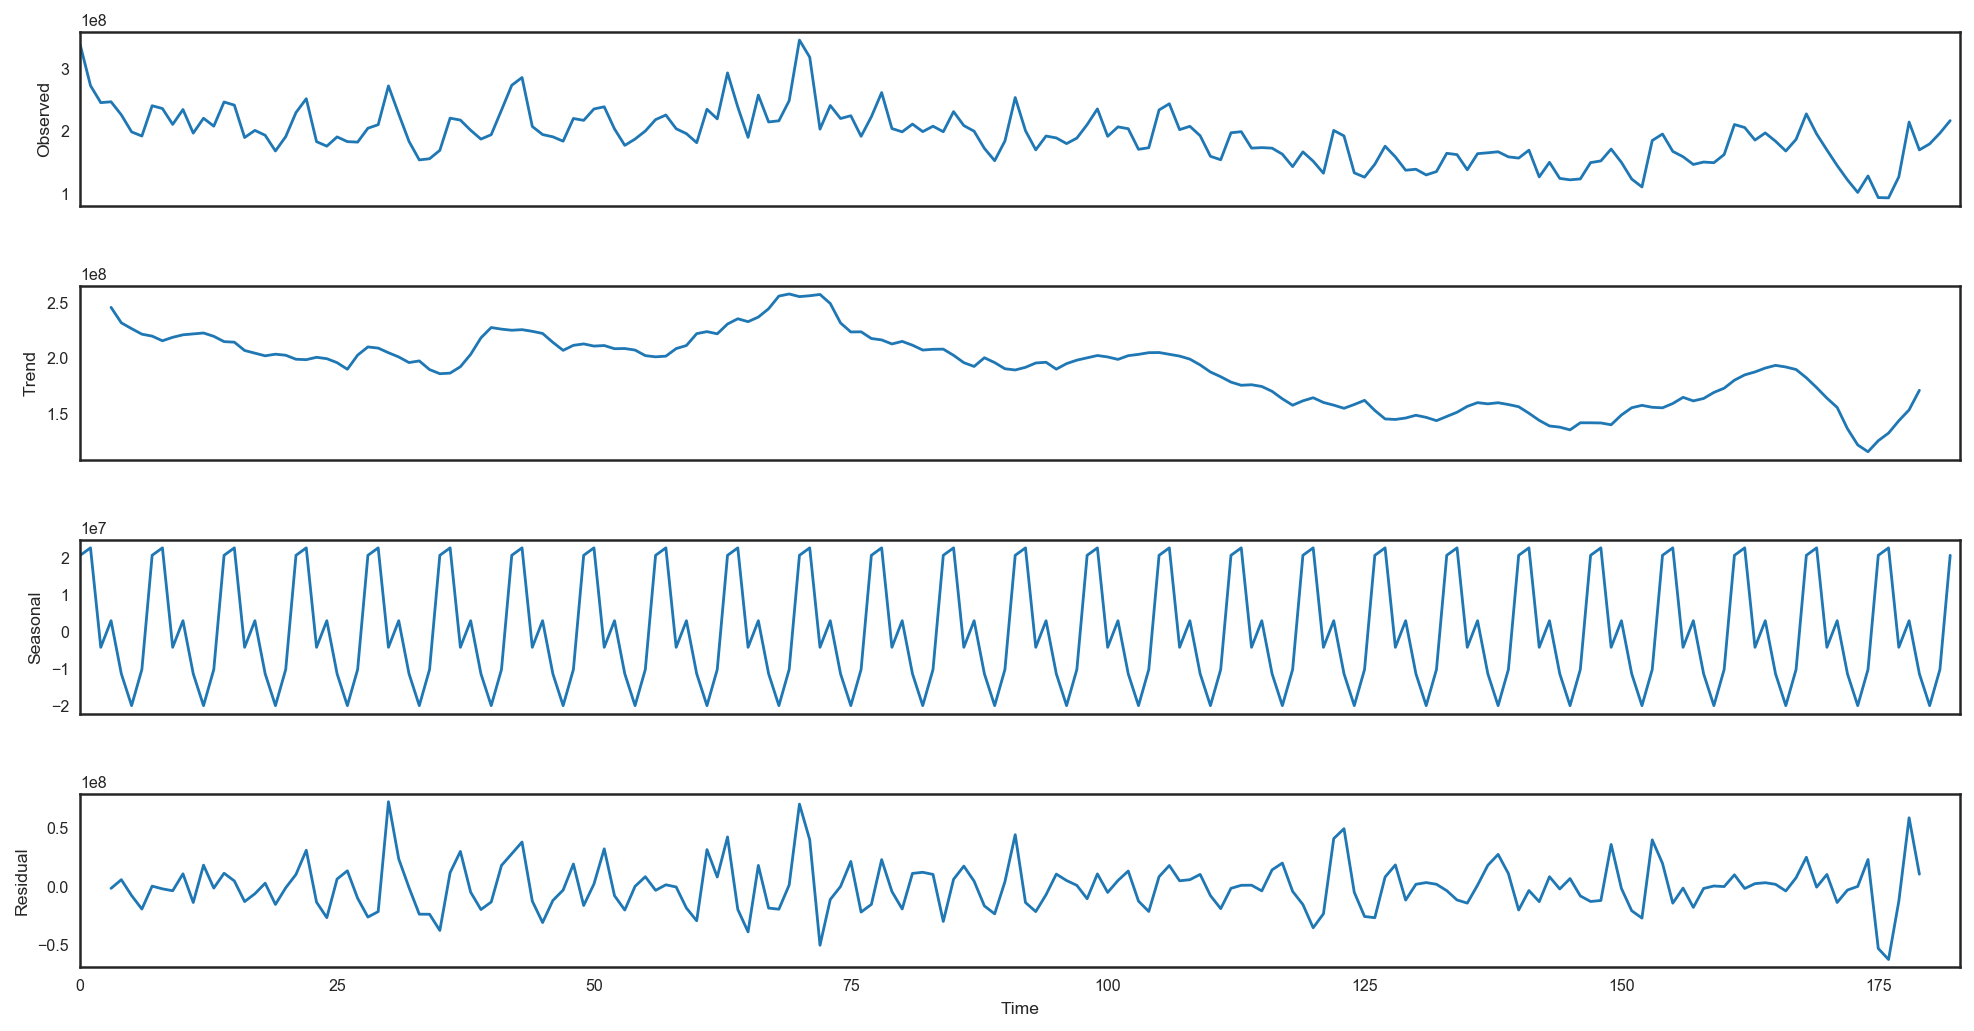

In [7]:
decomposition = sm.tsa.seasonal_decompose(X, freq=7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [8]:
# 기존 dataframe 일주일치로 묶기
f_clothes_total['WEEK'] = range(0, 183)
f_clothes_total['WEEK'] = f_clothes_total['WEEK'].map(lambda x: x//7)

# 마지막 하루는 빼기
f_clothes_total = f_clothes_total[:-1]

In [9]:
# WEEK를 기준으로 groupby
f_clothes_total_week=f_clothes_total.groupby(['WEEK']).sum().reset_index()

In [10]:
# 추후에 쓸 regression data를 위해 데이터프레임 copy해놓기
f_clothes_regdata = f_clothes_total_week.copy()

In [11]:
# 시계열 식에 들어갈 column만 뽑기
f_clothes_week_time_df=f_clothes_total_week[['WEEK','PD_BUY_TO']]

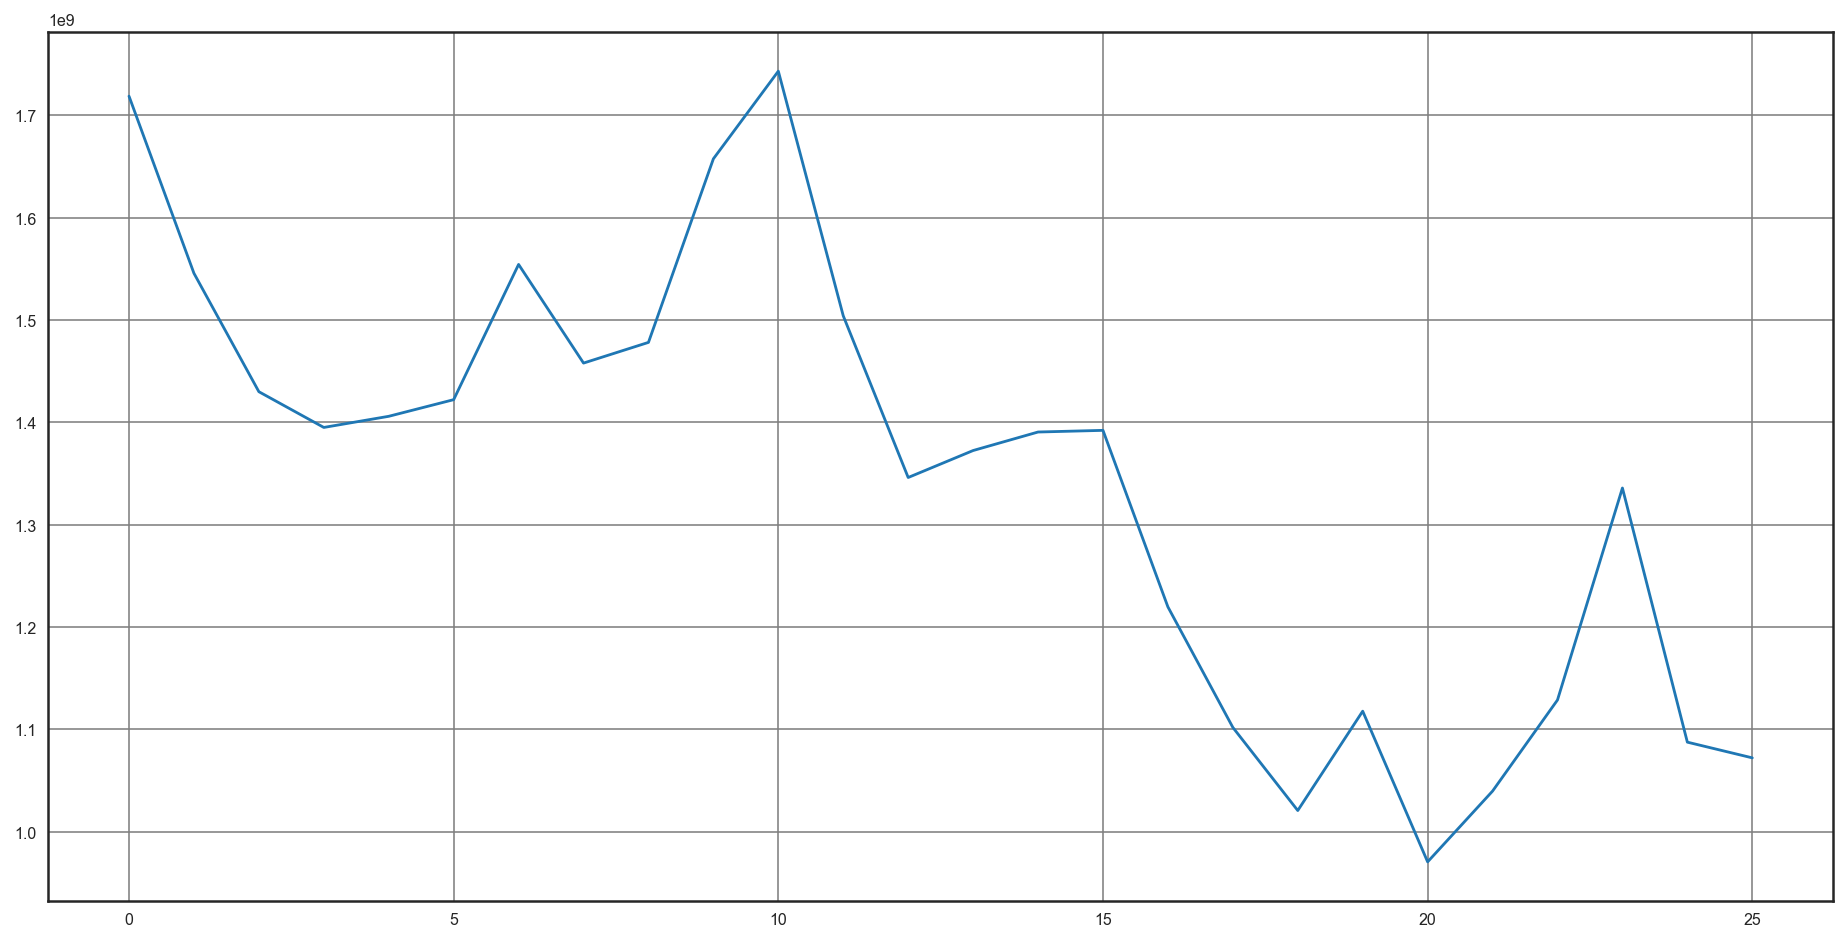

In [12]:
# 그리기
f_clothes_week_fig = plt.figure(figsize=(16,8))
plt.plot(f_clothes_week_time_df['WEEK'],f_clothes_week_time_df['PD_BUY_TO'])
plt.grid(color='grey', axis='both' )

In [13]:
# 저장
f_clothes_week_fig.savefig('f_clothes_week_fig.png')

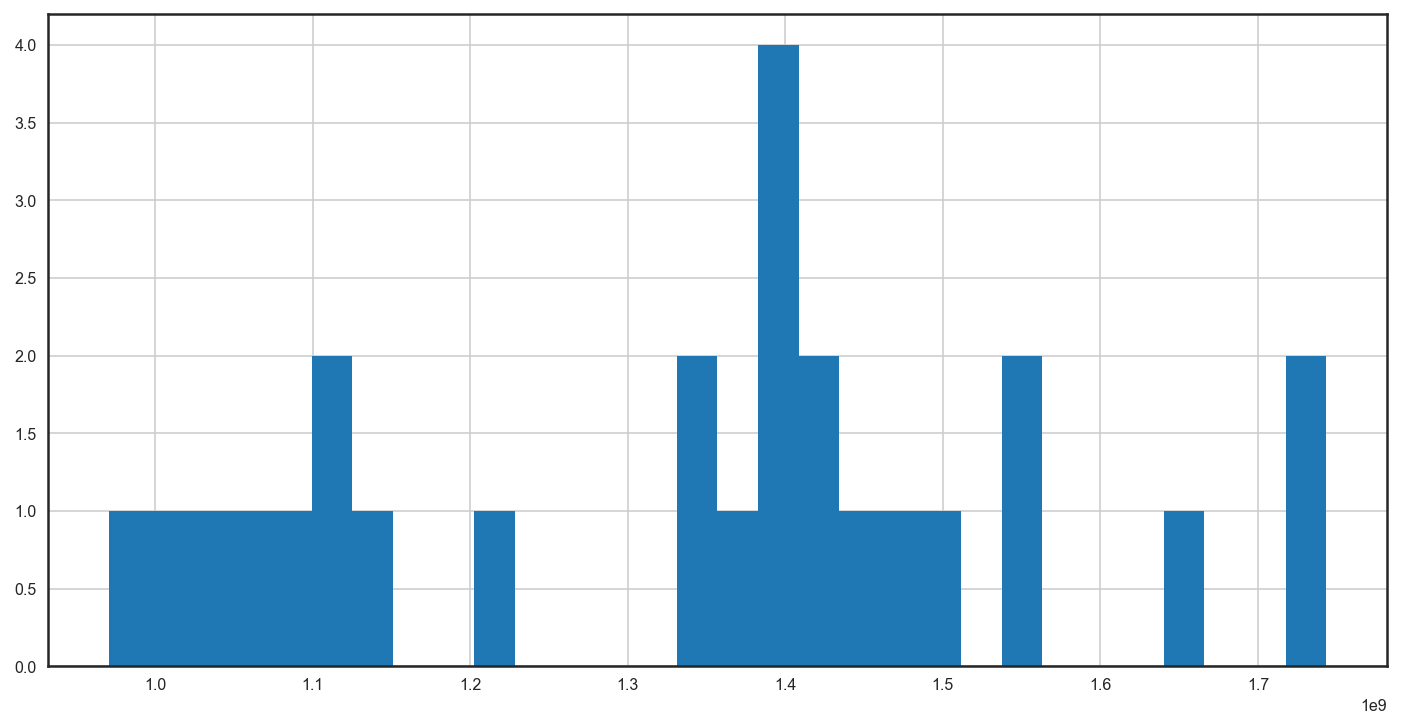

In [14]:
# 분포확인
f_clothes_week_time_df['PD_BUY_TO'].hist(bins=30, figsize=(12,6))

## 정상성(단위근) 검정 with Augmented Dickey Fuller TEST

In [15]:
# log 변환 후 검정 
log_f_clothes_week_X = np.log(f_clothes_week_time_df['PD_BUY_TO']).values
log_f_clothes_week_result = adfuller(log_f_clothes_week_X)

In [16]:
print('ADF Statistic: %f' % log_f_clothes_week_result[0])
print('p-value: %f' % log_f_clothes_week_result[1])
print('Critical Values:')


for key, value in log_f_clothes_week_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.977735
p-value: 0.761298
Critical Values:
	1%: -3.788
	5%: -3.013
	10%: -2.646


C:\Users\hyunj\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


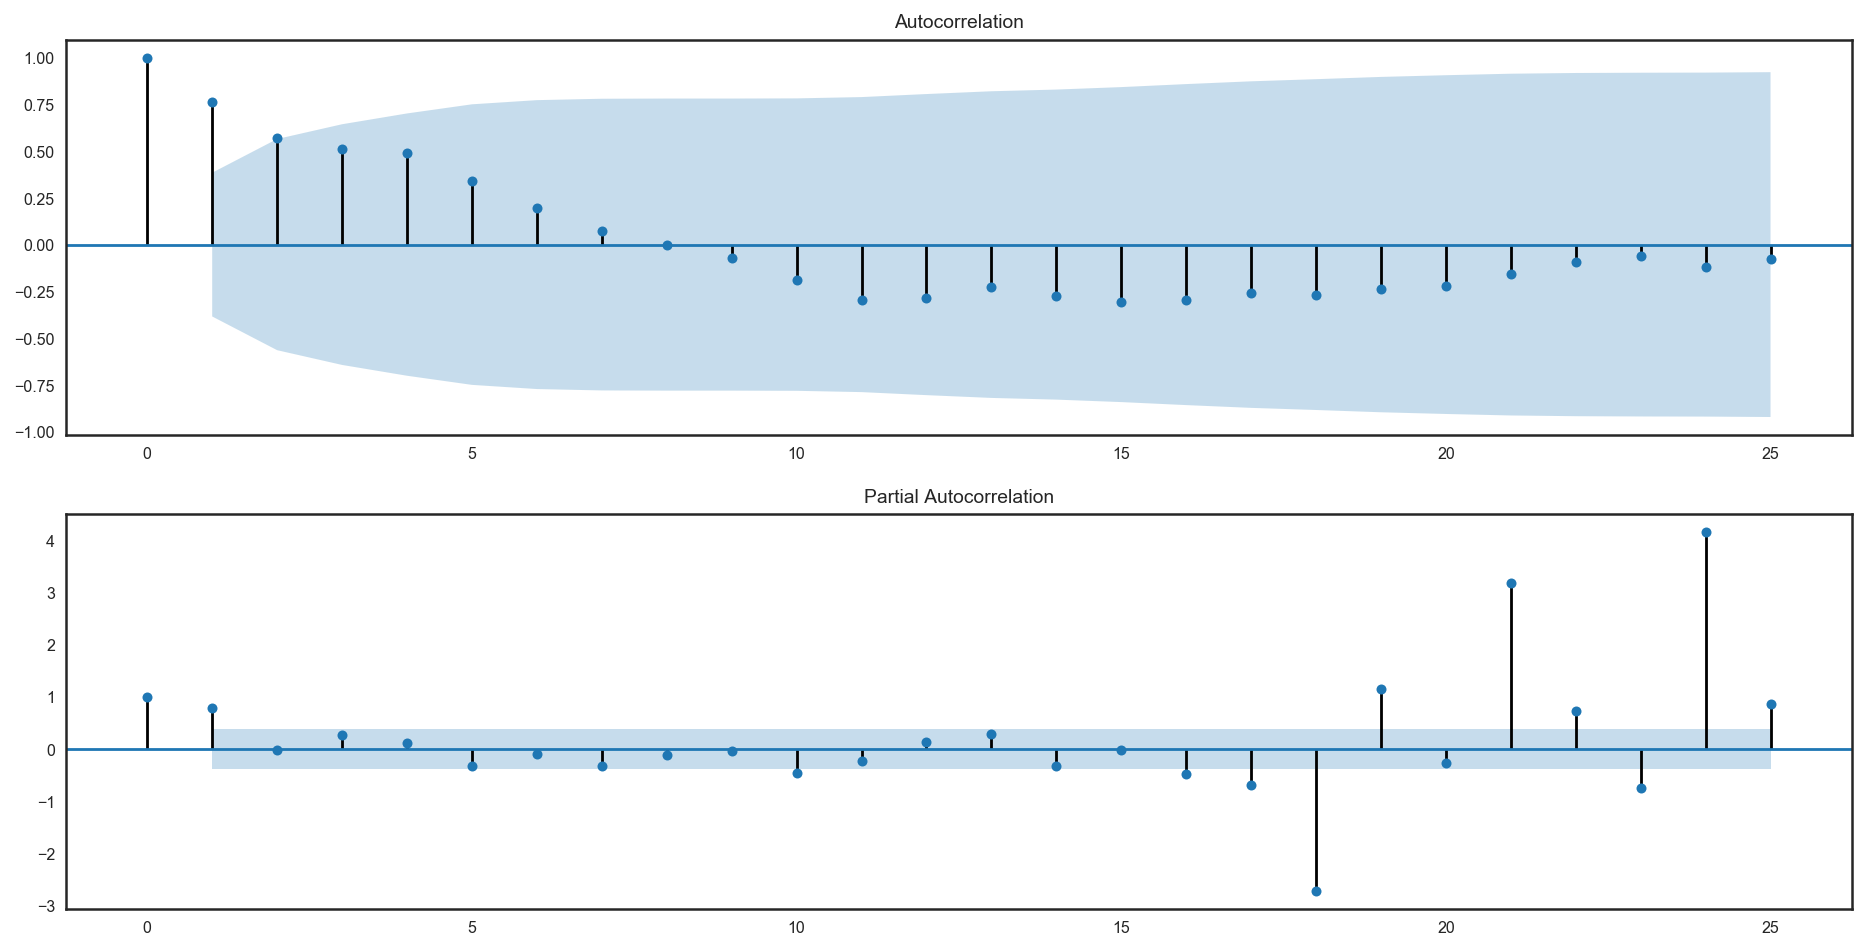

In [17]:
# acf & pacf 그래프 그리기
plt.figure(figsize=(16,8))
plt.subplot(211)
plot_acf(log_f_clothes_week_X, ax=plt.gca())
plt.subplot(212)
plot_pacf(log_f_clothes_week_X, ax=plt.gca())

plt.show()

## 정상성을 만족하지 않아 1차 차분을 한다.

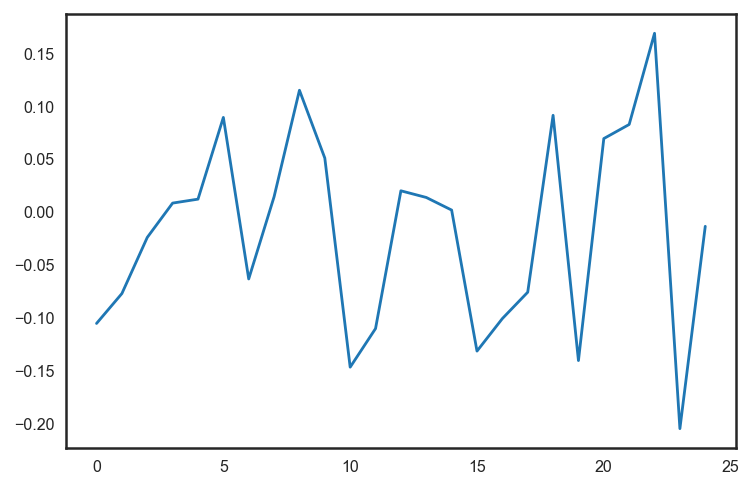

In [18]:
# create a differenced series
def difference(dataset, interval=1):
    diff_week = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff_week.append(value)
    return Series(diff_week)
 
diff_week = difference(log_f_clothes_week_X)
plt.plot(diff_week)
plt.show()

C:\Users\hyunj\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


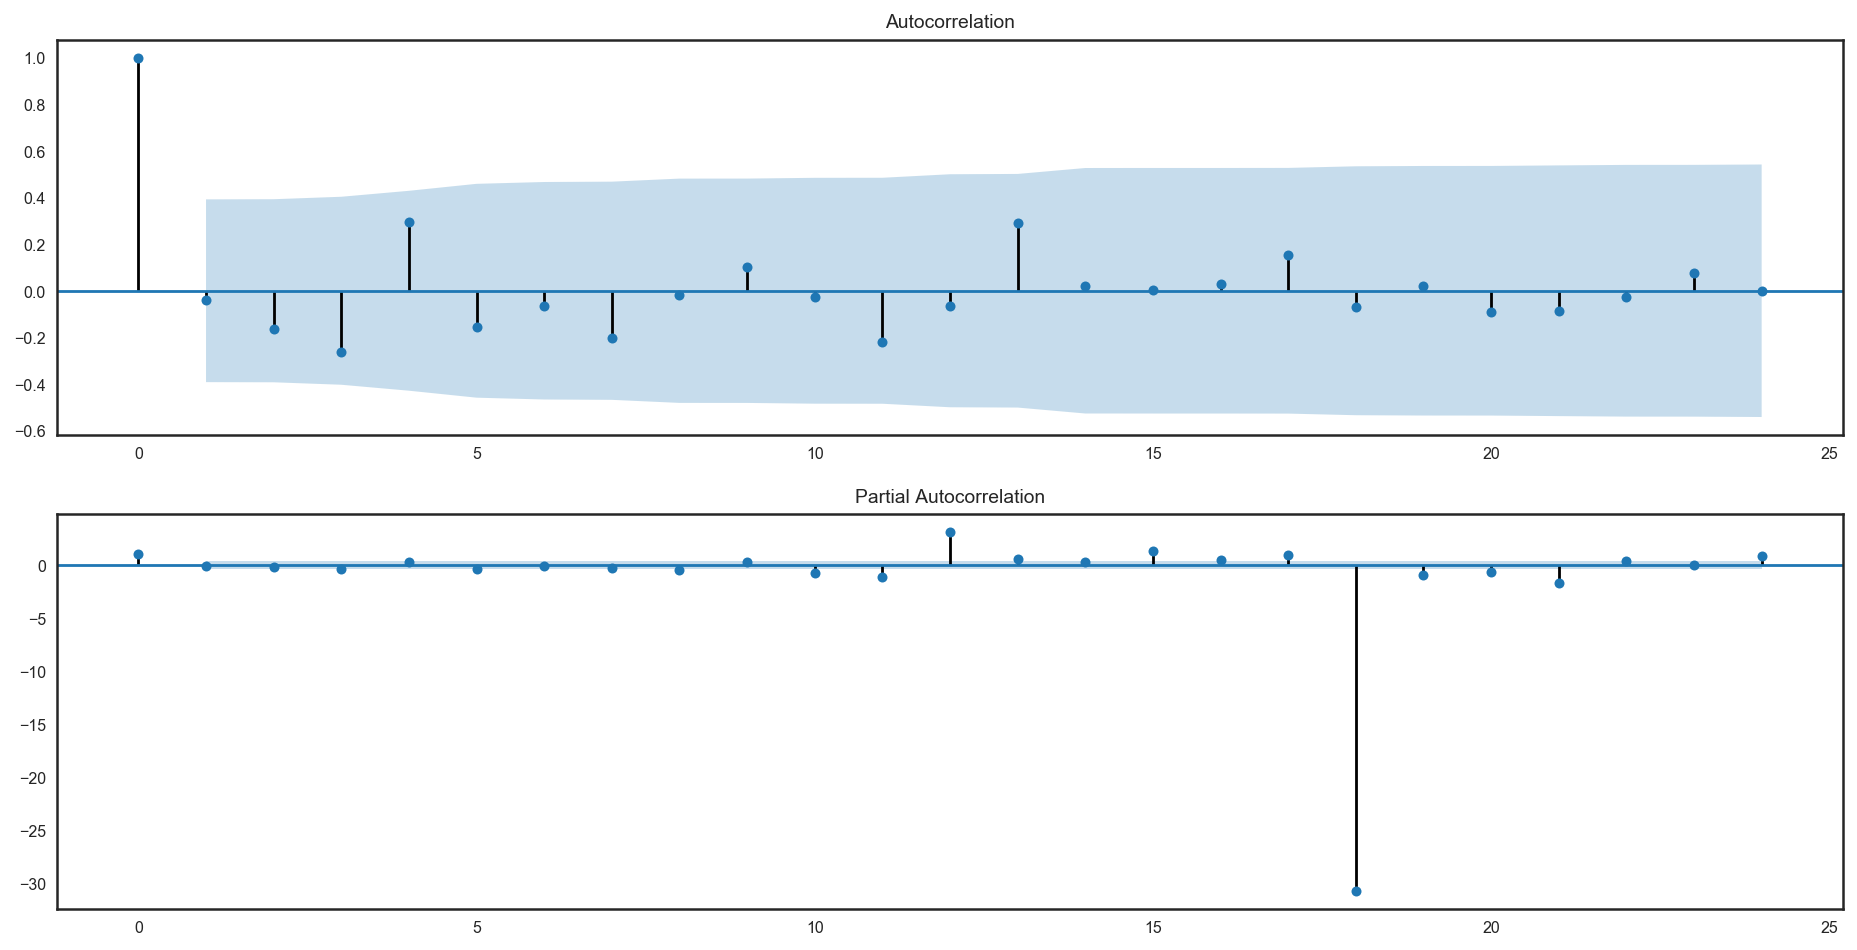

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(211)
plot_acf(diff_week, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff_week, ax=plt.gca())
plt.show()

In [20]:
X_week = diff_week
result_week = adfuller(X_week)
print('ADF Statistic: %f' % result_week[0])
print('p-value: %f' % result_week[1])
for key, value in result_week[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.176087
p-value: 0.021411
	1%: -3.964
	5%: -3.085
	10%: -2.682


In [21]:
f_clothes_week_time_df.to_csv('f_clothes_week_time_df_arima.csv')

In [22]:
f_clothes_week_time_df_arima = pd.read_csv('f_clothes_week_time_df_arima.csv', index_col=1)
f_clothes_week_time_df_arima = f_clothes_week_time_df_arima.drop('Unnamed: 0',axis=1)

f_clothes_week_time_df_arima['PD_BUY_TO']=f_clothes_week_time_df_arima['PD_BUY_TO'].map(lambda x: np.log(x))
f_clothes_week_time_df_arima.head()

,PD_BUY_TO
WEEK,
0,21.264927
1,21.158805
2,21.080986
3,21.056267
4,21.064038


In [23]:
# 앞 23주로 뒤 3주를 예측하는 arima 모형 만들기
f_clothes_week_time_df_arima_train=f_clothes_week_time_df_arima[:-3]

In [24]:
f_clothes_week_stepwise_model = auto_arima(f_clothes_week_time_df_arima_train, start_p=0, start_q=0,
                           max_p=3, max_q=3,
                           seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(f_clothes_week_stepwise_model.aic())

Fit ARIMA: order=(0, 1, 0); AIC=-43.917, BIC=-41.735, Fit time=0.027 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-41.992, BIC=-38.719, Fit time=0.082 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-42.056, BIC=-38.783, Fit time=0.055 seconds
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.191 seconds
-43.91685335817556


### p,d,q=(0, 1, 0)  AIC=-43.917, BIC=-41.735로 선택

In [25]:
f_clothes_week_mod = sm.tsa.statespace.SARIMAX(f_clothes_week_time_df_arima_train,
                                order=(0, 1, 0),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

f_clothes_week_results = f_clothes_week_mod.fit()

print(f_clothes_week_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0070      0.003      2.203      0.028       0.001       0.013


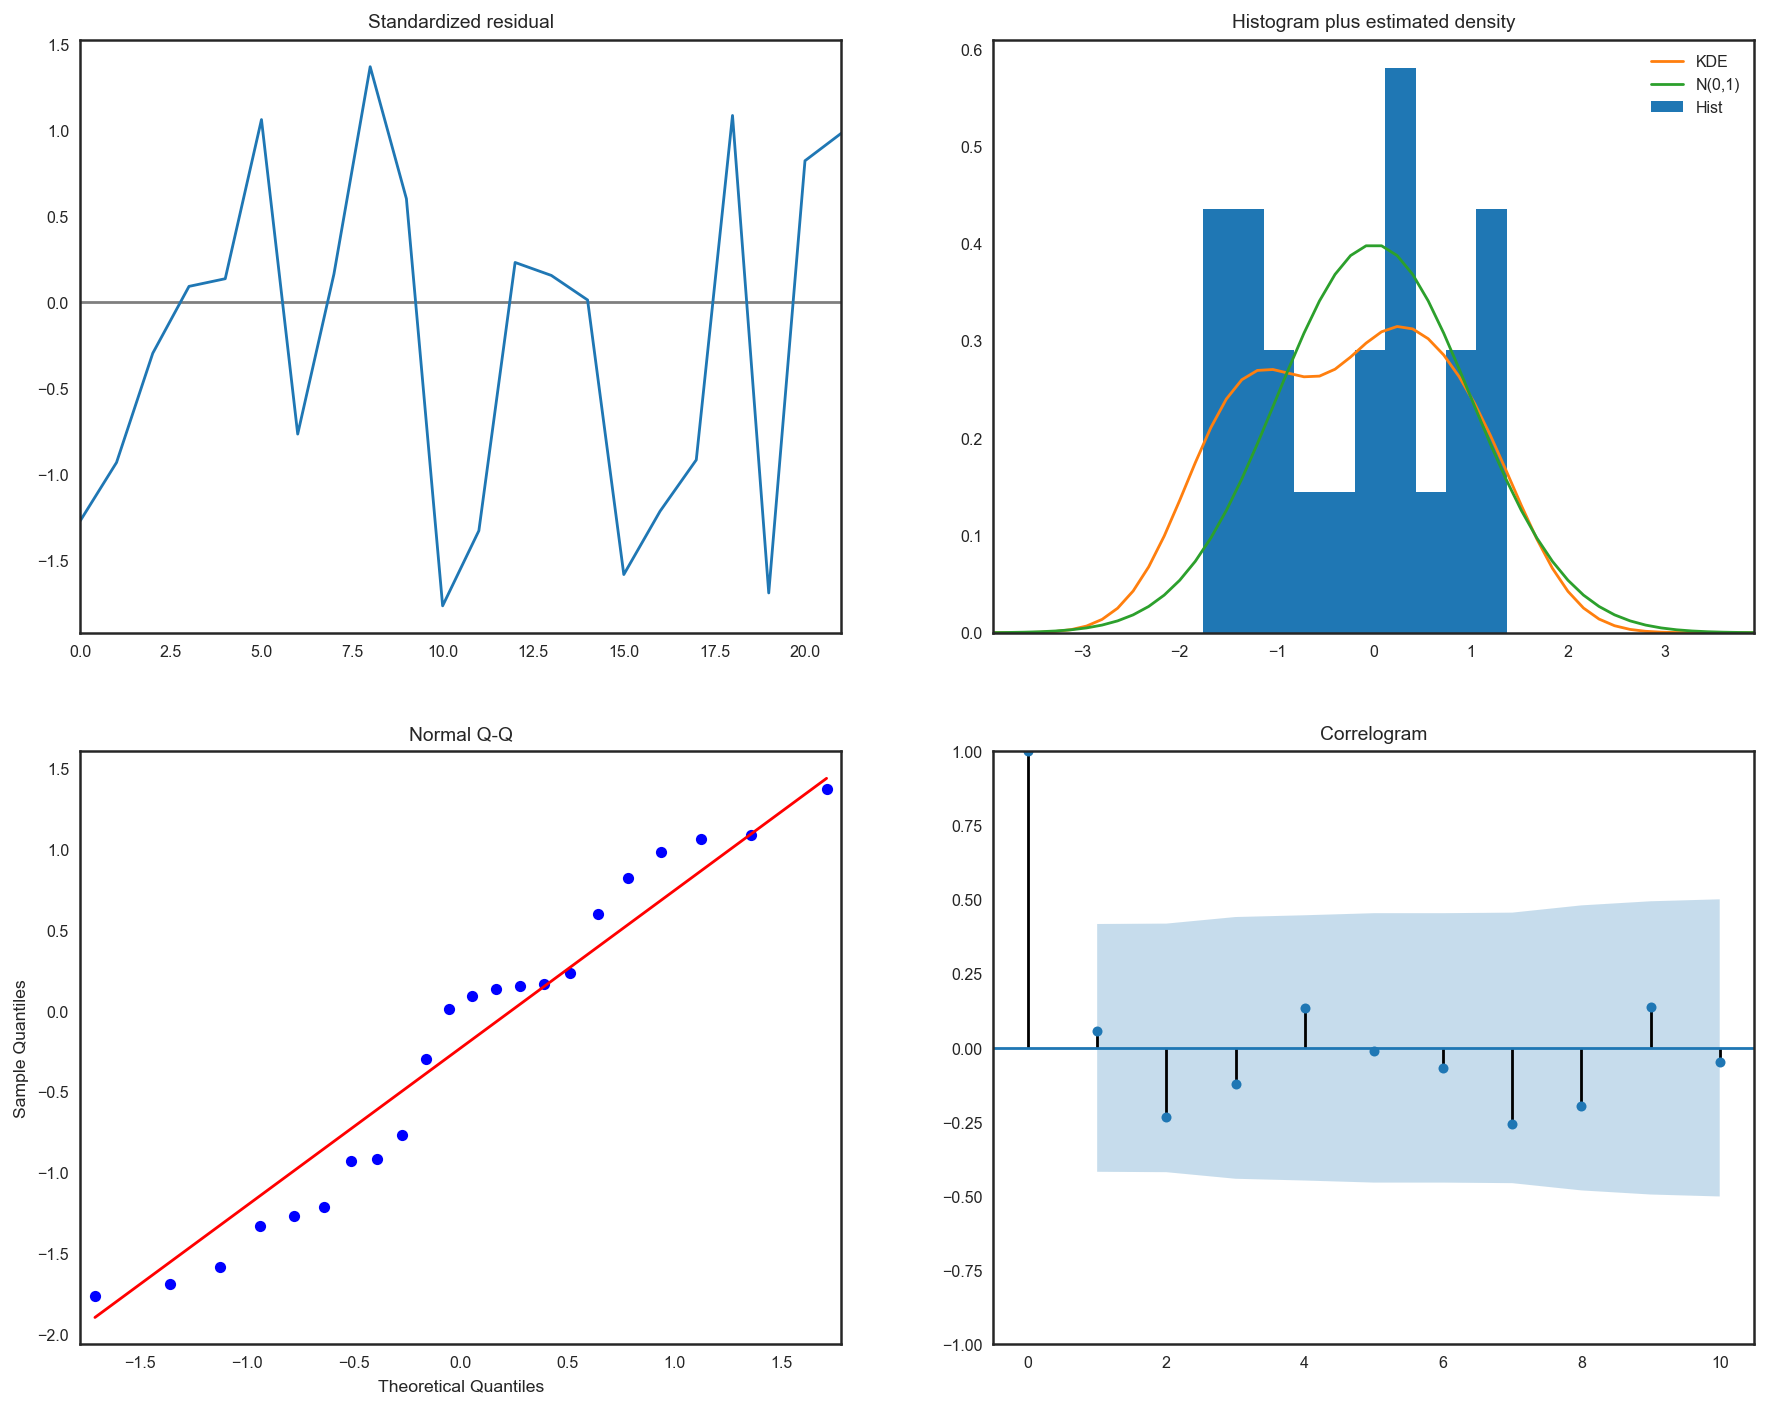

In [26]:
# 잔차 체크
f_clothes_week_results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [27]:
# Get forecast 3 steps(23, 24, 25주차) ahead in future
f_clothes_week_pred_uc = f_clothes_week_results.get_forecast(steps=3)

# Get confidence intervals of forecasts
f_clothes_week_pred_ci = np.exp(f_clothes_week_pred_uc.conf_int())

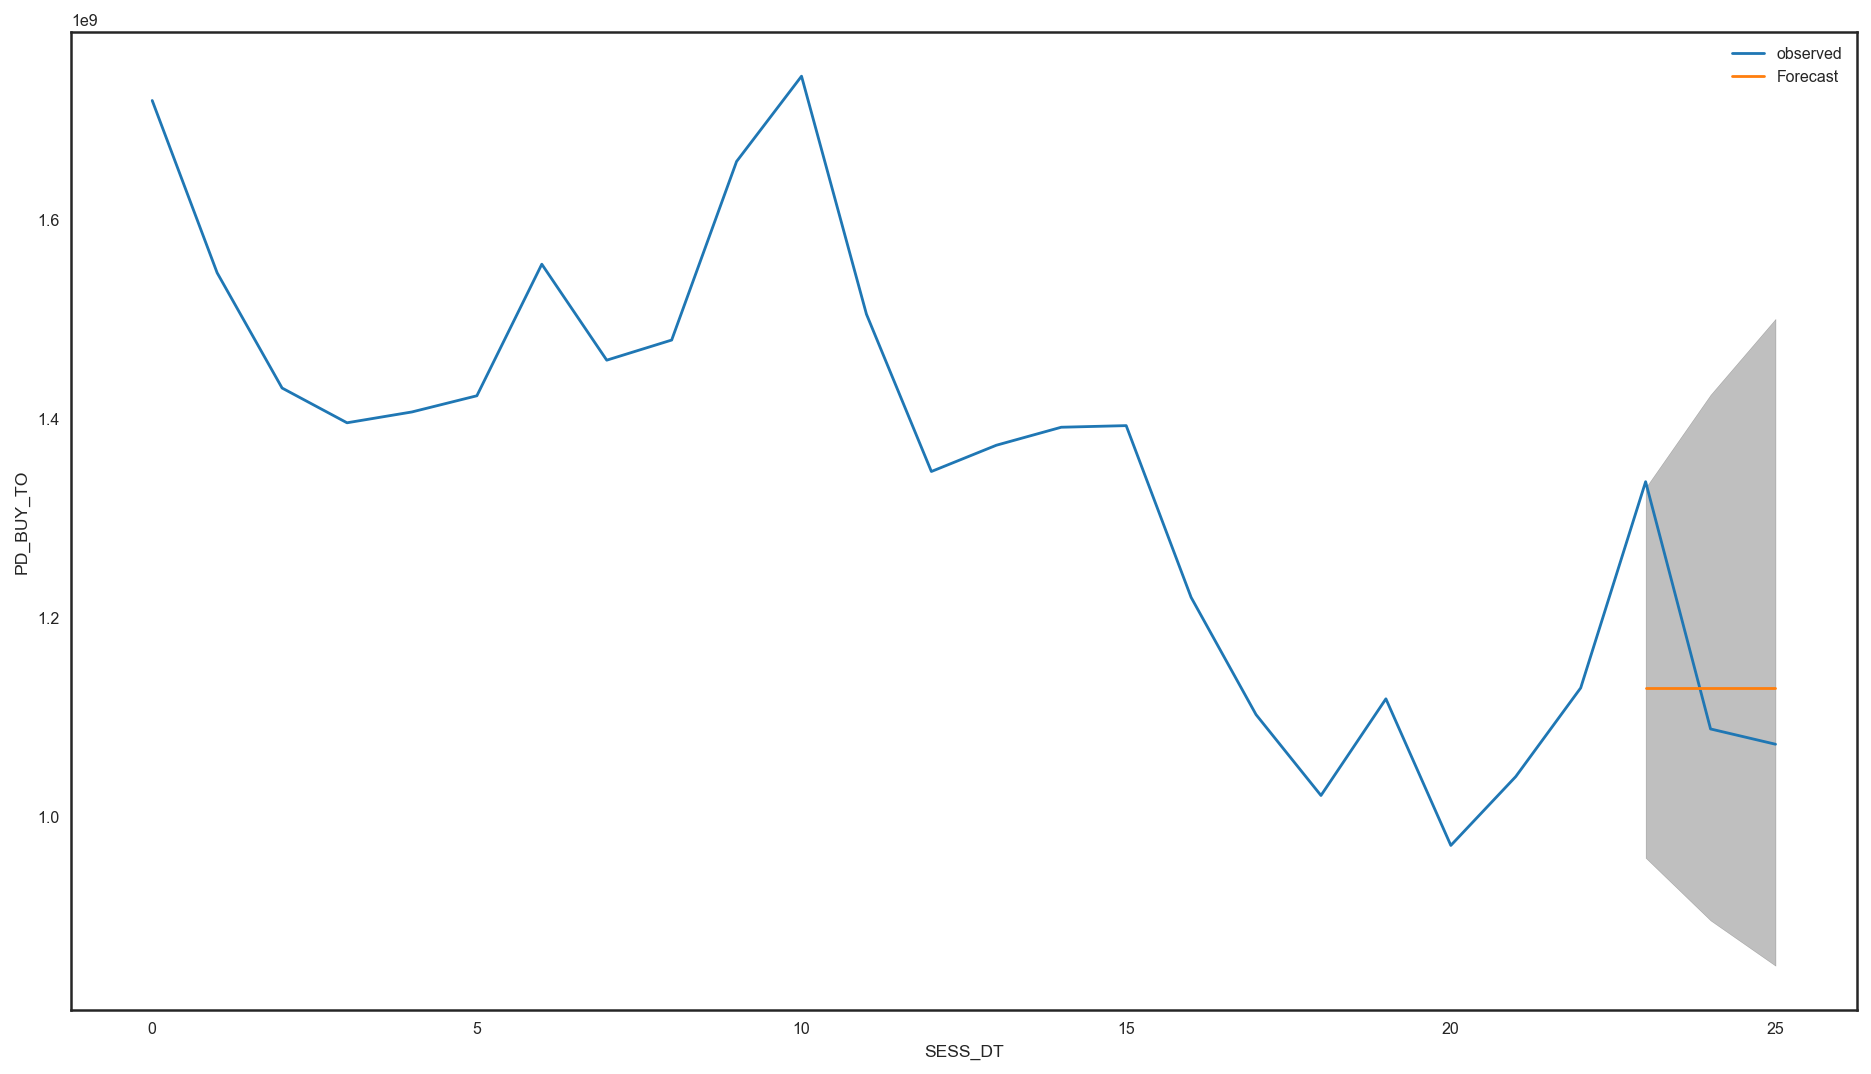

In [28]:
ax = f_clothes_week_time_df.iloc[0:,1].plot(label='observed', figsize=(16, 9))
np.exp(f_clothes_week_pred_uc.predicted_mean).plot(ax=ax, label='Forecast')
ax.fill_between(f_clothes_week_pred_ci.index,
                f_clothes_week_pred_ci.iloc[:, 0],
                f_clothes_week_pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('SESS_DT')
ax.set_ylabel('PD_BUY_TO')

plt.legend()
plt.show()

In [29]:
exp_f_clothes_y_forecasted = np.exp(f_clothes_week_pred_uc.predicted_mean)
f_clothes_week_y_truth = f_clothes_week_time_df['PD_BUY_TO'].iloc[23:].values

# Compute the mean absolute percentage error
f_clothes_mape = 100* (abs((exp_f_clothes_y_forecasted - f_clothes_week_y_truth)/f_clothes_week_y_truth).mean())
print('The Mean Absolute Percentage Error is {}'.format(round(f_clothes_mape,2)))

The Mean Absolute Percentage Error is 8.19


# Regression Analysis

In [30]:
f_clothes_regdata.head()

,WEEK,SESS_DT,CLNT_ID,SESS_ID,HITS_SEQ,SESS_SEQ,ONE_PAG_HR_V,TOT_SESS_HR_V,PD_BUY_TO,SEARCH_CNT,MONTH,WEEKDAY,DVC_CTG_NM_mobile,DVC_CTG_NM_not_mobile,ZON_NM_Gyeonggi-do,ZON_NM_Seoul,ZON_NM_city,ZON_NM_not_city,CLNT_GENDER_F,CLNT_GENDER_M,CLNT_AGE_30.0,CLNT_AGE_40.0,CLNT_AGE_old,CLNT_AGE_young,DAY_first,DAY_second,DAY_third,CLAC1_NM_가구,CLAC1_NM_건강식품,CLAC1_NM_계절가전,CLAC1_NM_과일,CLAC1_NM_구기/필드스포츠,CLAC1_NM_남성의류,CLAC1_NM_냉동식품,CLAC1_NM_냉장/세탁가전,CLAC1_NM_냉장식품,CLAC1_NM_모바일,CLAC1_NM_문구/사무용품,CLAC1_NM_상품권,CLAC1_NM_생활/주방가전,CLAC1_NM_세제/위생,CLAC1_NM_속옷/양말/홈웨어,CLAC1_NM_스포츠패션,CLAC1_NM_시즌스포츠,CLAC1_NM_식기/조리기구,CLAC1_NM_아웃도어/레저,CLAC1_NM_여성의류,CLAC1_NM_영상/음향가전,CLAC1_NM_완구,CLAC1_NM_원예/애완,CLAC1_NM_유아동의류,CLAC1_NM_음료,CLAC1_NM_인테리어/조명,CLAC1_NM_자동차용품,CLAC1_NM_주방잡화,CLAC1_NM_청소/세탁/욕실용품,CLAC1_NM_축산물,CLAC1_NM_출산/육아용품,CLAC1_NM_침구/수예,CLAC1_NM_컴퓨터,CLAC1_NM_패션잡화,CLAC1_NM_퍼스널케어,CLAC1_NM_헬스/피트니스,CLAC1_NM_화장품/뷰티케어
0,0,141262828,58280456778,193776062023,1.382519e+06,2994030.0,350528.237300,29317338.0,1718859380,6906,71952,53296,15033,2955,3062,6682,4652,3592,17106,882,6636,7740,2431,1181,17988,0,0,17,79,1,25,33,1560,19,0,9,20,37,1,45,31,522,649,71,71,58,17988,0,31,43,459,23,7,0,41,47,4,98,65,15,851,140,39,417
1,1,141262877,54272334494,172705553805,1.288628e+06,2967853.0,324824.374838,27439927.0,1545795509,6494,66828,48835,13954,2753,2944,6171,4238,3354,15990,717,6100,7382,2317,908,7504,9203,0,15,71,4,25,26,1370,12,0,9,22,44,1,31,56,414,596,81,75,30,16707,3,24,41,336,36,4,0,47,42,1,83,44,12,730,121,35,402
2,2,141262926,49923217168,152723177689,1.166616e+06,2893248.0,308404.432887,25523818.0,1430065370,6469,61588,44979,12671,2726,2677,5639,3969,3112,14712,685,5439,6959,2228,771,0,13417,1980,20,79,1,25,30,1273,14,0,6,12,43,4,20,36,373,600,76,72,33,15397,3,26,35,380,30,4,1,43,35,2,75,47,7,744,113,30,408
3,3,141262975,48465332832,142235958595,1.177951e+06,2848574.0,287146.608282,24926403.0,1395149318,6180,59908,44378,12409,2568,2631,5570,3861,2915,14318,659,5391,6667,2163,756,0,0,14977,29,110,3,28,34,1225,16,0,11,22,53,2,32,50,426,627,63,80,34,14977,0,65,41,366,57,3,0,49,42,2,87,36,8,762,128,32,440
4,4,141263374,48799018028,137033732949,1.204907e+06,2957892.0,286150.742980,25250691.0,1406033210,6325,71001,41785,12595,2496,2583,5695,3893,2920,14422,669,5165,6864,2155,907,10637,0,4454,16,113,5,20,36,1266,9,1,10,16,41,1,31,49,450,627,76,64,40,15091,3,60,48,363,32,10,0,54,31,2,104,55,10,773,127,38,467


In [31]:
feature_cols=['WEEK','HITS_SEQ','ONE_PAG_HR_V','TOT_SESS_HR_V','PD_BUY_TO','SEARCH_CNT','DVC_CTG_NM_mobile','DVC_CTG_NM_not_mobile','ZON_NM_Gyeonggi-do', 'ZON_NM_Seoul', 'ZON_NM_city', 'ZON_NM_not_city',
       'CLNT_GENDER_F', 'CLNT_GENDER_M', 'CLNT_AGE_30.0', 'CLNT_AGE_40.0',
       'CLNT_AGE_old', 'CLNT_AGE_young']

In [32]:
f_clothes_week_reg = f_clothes_regdata[feature_cols]

In [33]:
# 외부데이터 weather 불러오기
weather = pd.read_csv('weather.csv')

weather['WEEK'] = range(0, 183)
weather['WEEK'] = weather['WEEK'].map(lambda x: x//7)

weather_week=weather.groupby('WEEK').mean().reset_index()

In [34]:
# 마지막 남은 하루 지우기
weather_week = weather_week[:-1]

In [35]:
# 외부데이터 naver_search & holiday 불러오기
naver_search_holiday_week = pd.read_csv('naver_search_holiday_week.csv')

naver_search_holiday_week['WEEK']=range(0,26)

In [36]:
# 세 외부데이터 merge
out_data=pd.merge(naver_search_holiday_week, weather_week, how='left', on='WEEK')
out_data.drop('WEEK',axis=1,inplace=True)

In [37]:
f_clothes_regdata = pd.concat([f_clothes_week_reg, out_data], axis=1)

In [38]:
# HITS_SEQ는 순서를 나타내 count가 더 적절하므로 count값으로 바꿔준다.
f_clothes_regdata['HITS_SEQ'] = f_clothes_regdata['DVC_CTG_NM_mobile'] + f_clothes_regdata['DVC_CTG_NM_not_mobile']

In [39]:
# df 한줄씩 옮기기
f_clothes_regdata.WEEK = f_clothes_regdata.WEEK[1:].reset_index(drop = True)
f_clothes_regdata.PD_BUY_TO = f_clothes_regdata.PD_BUY_TO[1:].reset_index(drop = True)

In [40]:
# 복사 해놓기
f_clothes_regdata_final = f_clothes_regdata.copy()

In [41]:
# 마지막 prediction용 row 삭제
f_clothes_regdata=f_clothes_regdata[:-1]

In [42]:
# pandas_profiling html 만들기
profile = pandas_profiling.ProfileReport(f_clothes_regdata)
profile.to_file(outputfile="f_clothes_regdata.html")

### pandas_profiling으로 correlation이 높은 변수를 제외하고 남은 변수들 중 regression해서 유의한 변수: Avg_temp, HITS_SEQ, Prec, WEEK, Wet, holiday, naver_search

In [43]:
feature_cols2 = ['WEEK','HITS_SEQ','Avg_temp','Prec','Wet', 'holiday','naver_search','PD_BUY_TO']

In [44]:
f_clothes_regdata=f_clothes_regdata[feature_cols2]

In [45]:
f_clothes_regdata['ln_PD_BUY_TO']=f_clothes_regdata['PD_BUY_TO'].map(lambda x: np.log(x))
f_clothes_regdata.drop('PD_BUY_TO',axis=1, inplace=True)

In [46]:
# train data 뽑기
f_clothes_week_X1 = f_clothes_regdata.iloc[:22,1:7]
f_clothes_week_y1 = f_clothes_regdata.iloc[:22,7]

In [47]:
lm=linear_model.LinearRegression(normalize=True)
f_clothes_week_model1=lm.fit(f_clothes_week_X1,f_clothes_week_y1)

In [48]:
f_clothes_week_pred1 = lm.predict(f_clothes_week_X1)

In [49]:
# r^2
lm.score(f_clothes_week_X1,f_clothes_week_y1)

0.9085017830662233

In [50]:
f_clothes_week_X1_2 = sm.add_constant(f_clothes_week_X1)
f_clothes_week_est = sm.OLS(f_clothes_week_y1, f_clothes_week_X1_2)
f_clothes_week_est2 = f_clothes_week_est.fit()
print(f_clothes_week_est2.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_PD_BUY_TO   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     24.82
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           5.54e-07
Time:                        22:56:28   Log-Likelihood:                 35.600
No. Observations:                  22   AIC:                            -57.20
Df Residuals:                      15   BIC:                            -49.56
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           19.9370      0.198    100.913   

In [51]:
# 유의한 변수만 골라 다시 regression
feature_cols3 = ['WEEK','HITS_SEQ','holiday','naver_search','ln_PD_BUY_TO']
f_clothes_week_reg2=f_clothes_regdata[feature_cols3]

In [52]:
f_clothes_week_X2 = f_clothes_week_reg2.iloc[:22,1:4]
f_clothes_week_y2 = f_clothes_week_reg2.iloc[:22,4]

In [53]:
lm=linear_model.LinearRegression(normalize=True)
f_clothes_week_model2=lm.fit(f_clothes_week_X2,f_clothes_week_y2)

In [54]:
f_clothes_week_pred2 = lm.predict(f_clothes_week_X2)

In [56]:
f_clothes_week_X2_2 = sm.add_constant(f_clothes_week_X2)
f_clothes_week_est3 = sm.OLS(f_clothes_week_y2, f_clothes_week_X2_2)
f_clothes_week_est4 = f_clothes_week_est3.fit()
print(f_clothes_week_est4.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_PD_BUY_TO   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     54.73
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           3.02e-09
Time:                        22:56:35   Log-Likelihood:                 34.755
No. Observations:                  22   AIC:                            -61.51
Df Residuals:                      18   BIC:                            -57.15
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           19.7909      0.104    190.212   

In [57]:
# 잔차 체크
results1 = smfor.ols(formula='ln_PD_BUY_TO ~ HITS_SEQ', data=f_clothes_week_reg2).fit()
Y_pred1 = results1.predict(f_clothes_week_reg2["HITS_SEQ"])
residual1 = f_clothes_week_reg2["ln_PD_BUY_TO"].values - Y_pred1

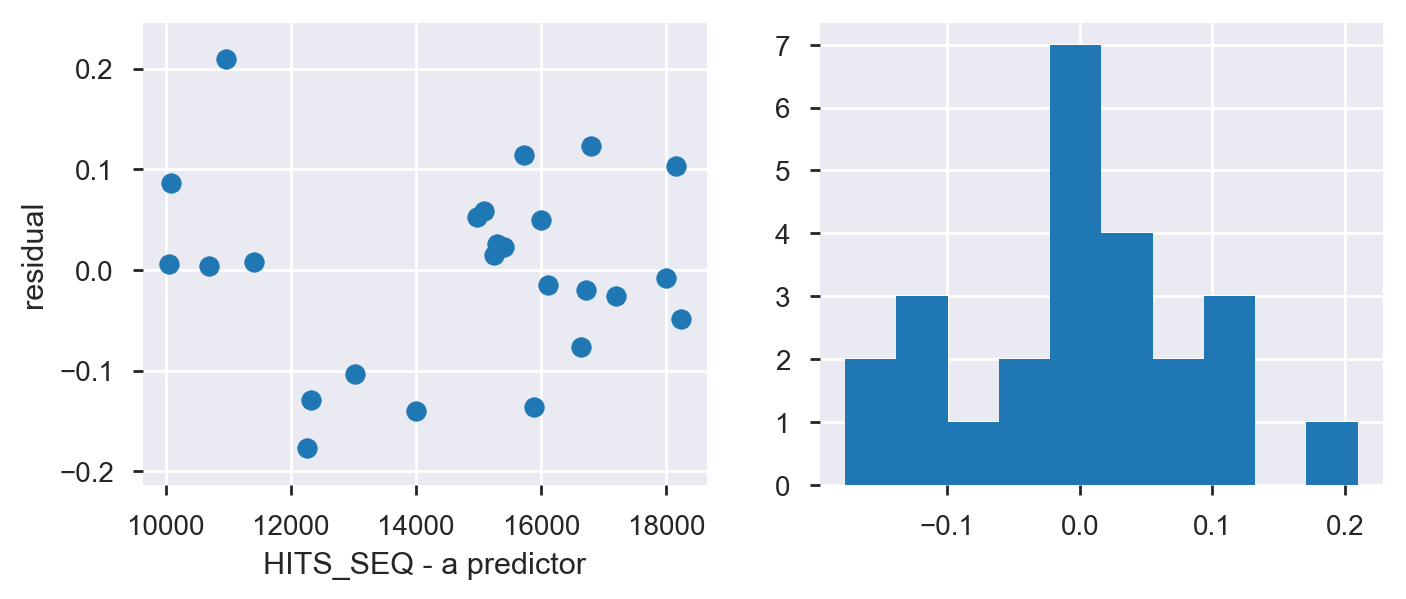

In [58]:
figs = plt.figure(figsize=(8,3))
plt.subplot(1, 2, 1)
plt.scatter(f_clothes_week_reg2[["HITS_SEQ"]],residual1)
plt.xlabel("HITS_SEQ - a predictor")
plt.ylabel("residual")

plt.subplot(1, 2, 2)
residual1.hist()

plt.show()

In [59]:
results2 = smfor.ols(formula='ln_PD_BUY_TO ~ naver_search', data=f_clothes_week_reg2).fit()
Y_pred2 = results2.predict(f_clothes_week_reg2["naver_search"])
residual2 = f_clothes_week_reg2["ln_PD_BUY_TO"].values - Y_pred2

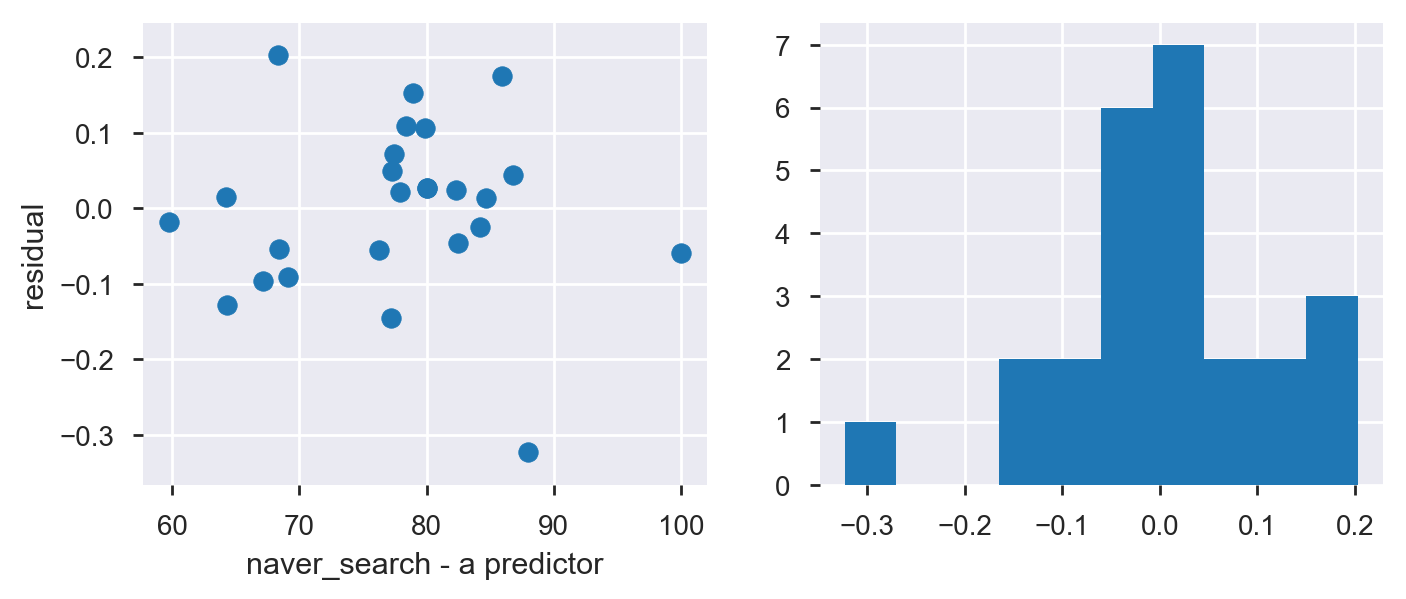

In [60]:
figs = plt.figure(figsize=(8,3))
plt.subplot(1, 2, 1)
plt.scatter(f_clothes_week_reg2[["naver_search"]],residual2)
plt.xlabel("naver_search - a predictor")
plt.ylabel("residual")

plt.subplot(1, 2, 2)
residual2.hist()

plt.show()

### Regression Validation

In [61]:
# 아까 copy해 두었던 dataframe
f_clothes_regdata.head()

,WEEK,HITS_SEQ,Avg_temp,Prec,Wet,holiday,naver_search,ln_PD_BUY_TO
0,1.0,17988,11.828571,5.114286,68.628571,0,86.82422,21.158805
1,2.0,16707,10.914286,2.428571,50.014286,0,82.32380,21.080986
2,3.0,15397,13.928571,0.000000,42.500000,0,84.22020,21.056267
3,4.0,14977,13.928571,11.071429,58.028571,0,77.44126,21.064038
4,5.0,15091,16.357143,1.857143,60.371429,1,68.28474,21.075535


In [62]:
f_clothes_regdata_val = f_clothes_regdata.drop(['WEEK','Avg_temp','Prec','Wet','ln_PD_BUY_TO'], axis=1)

In [63]:
# validation 할 부분 지정
f_clothes_regdata_val_final=f_clothes_regdata_val.iloc[22:,]

In [64]:
# 구축한 linear regression model에 적용
f_clothes_regdata_val_final_pred = lm.predict(f_clothes_regdata_val_final)

In [65]:
f_clothes_regdata_val_final_pred

array([20.9196578 , 21.03589725, 20.93009839])

In [66]:
# 실제 값
f_clothes_regdata['ln_PD_BUY_TO'].values[22:]

array([21.01291659, 20.80725694, 20.79304948])

In [67]:
f_clothes_reg_mape = 100* (abs(np.exp(f_clothes_regdata_val_final_pred) - np.exp(f_clothes_regdata['ln_PD_BUY_TO'].values[22:]))/np.exp(f_clothes_regdata['ln_PD_BUY_TO'].values[22:])).mean()
print('The Mean Absolute Percentage Error is {}'.format(round(f_clothes_reg_mape,2)))

The Mean Absolute Percentage Error is 16.43


In [68]:
f_clothes_results_arima = Series(np.exp(f_clothes_week_pred_uc.predicted_mean)).reset_index()
f_clothes_results_arima.drop('index',axis=1,inplace=True)

In [69]:
f_clothes_results_reg = Series(np.exp(f_clothes_regdata_val_final_pred))

In [70]:
f_clothes_results_all = pd.concat([f_clothes_results_arima, f_clothes_results_reg], axis=1)
f_clothes_results_all.columns = ['f_clothes_results_arima','f_clothes_results_reg']

In [71]:
f_clothes_results_all['ensemble'] = 0.5*f_clothes_results_all['f_clothes_results_arima'] + 0.5*f_clothes_results_all['f_clothes_results_reg']

In [72]:
f_clothes_ensemble_mape = 100* (abs((f_clothes_results_all['ensemble']) - np.exp(f_clothes_regdata['ln_PD_BUY_TO'].values[22:]))/np.exp(f_clothes_regdata['ln_PD_BUY_TO'].values[22:])).mean()
print('The Mean Absolute Percentage Error is {}'.format(round(f_clothes_ensemble_mape,2)))

The Mean Absolute Percentage Error is 12.31


In [73]:
f_clothes_results_all['index'] = range(23,26)

In [74]:
f_clothes_results_all = f_clothes_results_all.set_index('index')

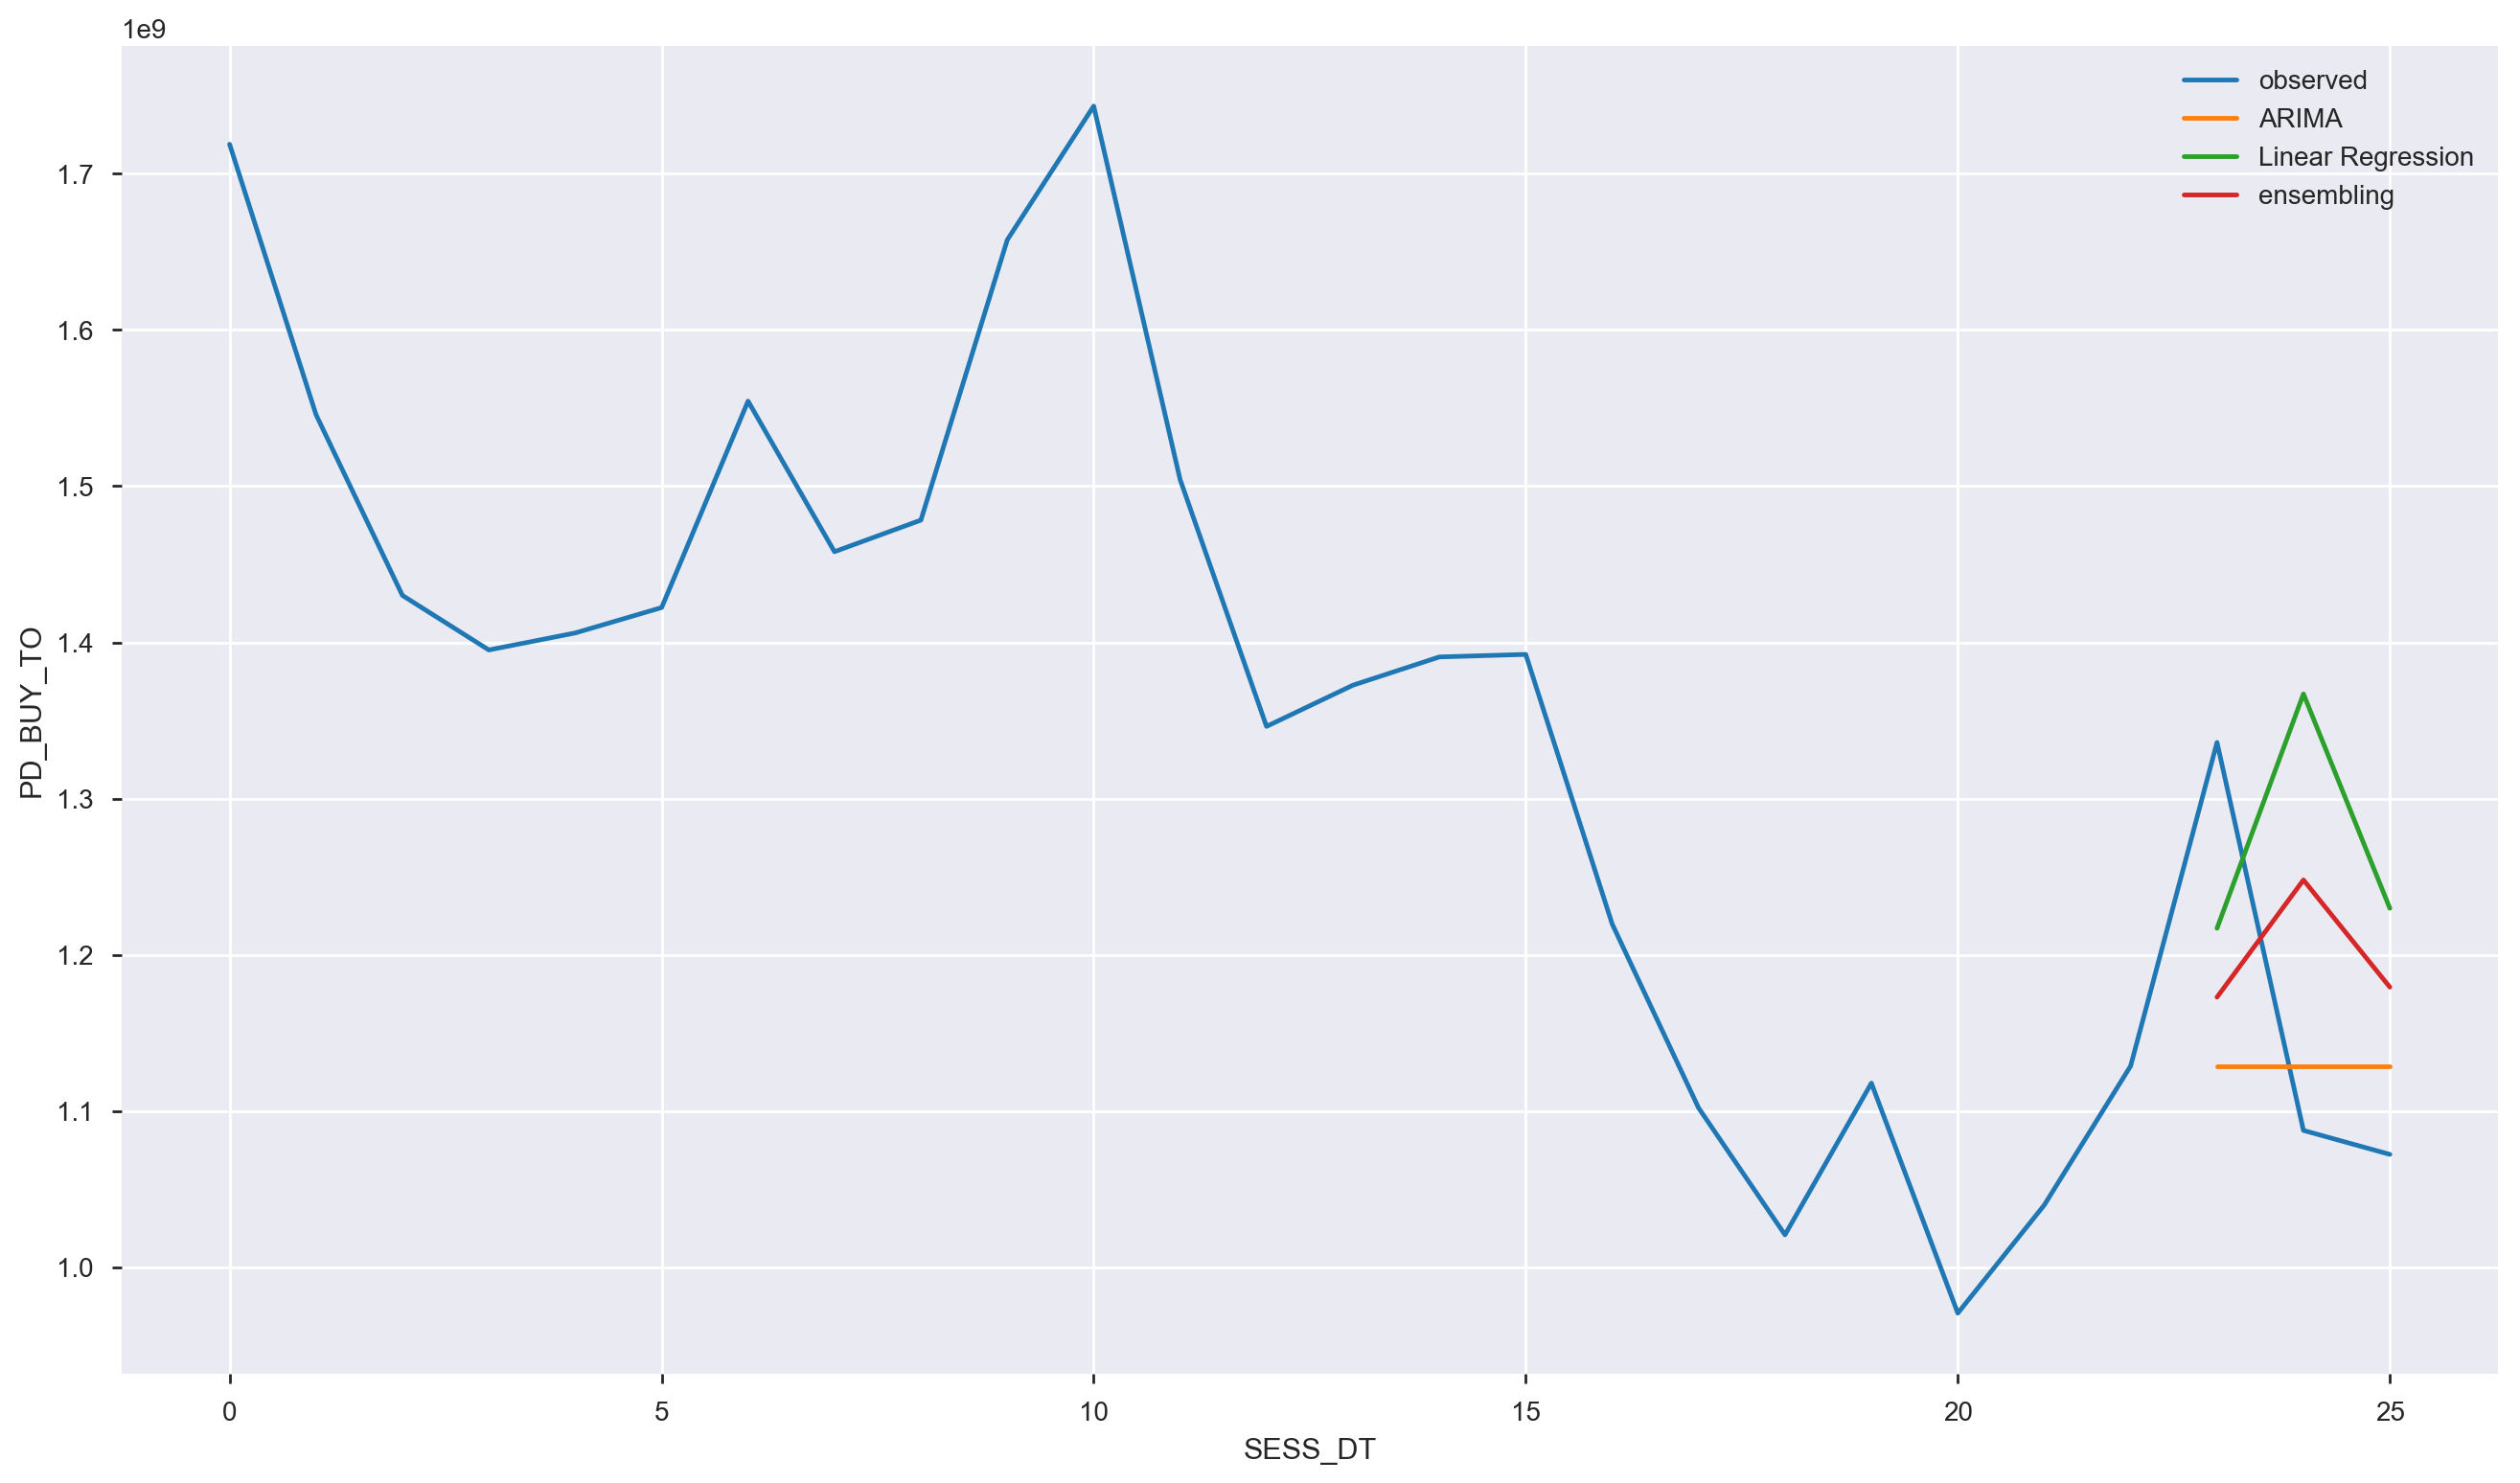

In [76]:
# validation 그리기
ax = f_clothes_week_time_df.iloc[0:,1].plot(label='observed', figsize=(16, 9))
f_clothes_results_all['f_clothes_results_arima'].plot(ax=ax, label='ARIMA')
f_clothes_results_all['f_clothes_results_reg'].plot(label='Linear Regression')
f_clothes_results_all['ensemble'].plot(label='ensembling')


ax.set_xlabel('SESS_DT')
ax.set_ylabel('PD_BUY_TO')

plt.legend()
plt.show()

# Prediction - validation 데이터까지 합쳐서 한 주 앞 매출 예측하기

## ARIMA

In [77]:
# 모든 데이터 바탕으로 arima 모델 만들기
f_clothes_week_stepwise_model_final = auto_arima(f_clothes_week_time_df_arima, start_p=0, start_q=0,
                           max_p=3, max_q=3, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(f_clothes_week_stepwise_model_final.aic())

Fit ARIMA: order=(0, 1, 0); AIC=-43.849, BIC=-41.411, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-41.890, BIC=-38.233, Fit time=0.032 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-41.913, BIC=-38.257, Fit time=0.027 seconds
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.089 seconds
-43.848632850129036


## (p,d,q)=(0, 1, 0); AIC=-43.849, BIC=-41.411로 이전과 모델 동일

In [78]:
f_clothes_week_mod_final = sm.tsa.statespace.SARIMAX(f_clothes_week_time_df_arima,
                                order=(0, 1, 0),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

f_clothes_week_results_final = f_clothes_week_mod_final.fit()

print(f_clothes_week_results_final.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0090      0.003      2.836      0.005       0.003       0.015


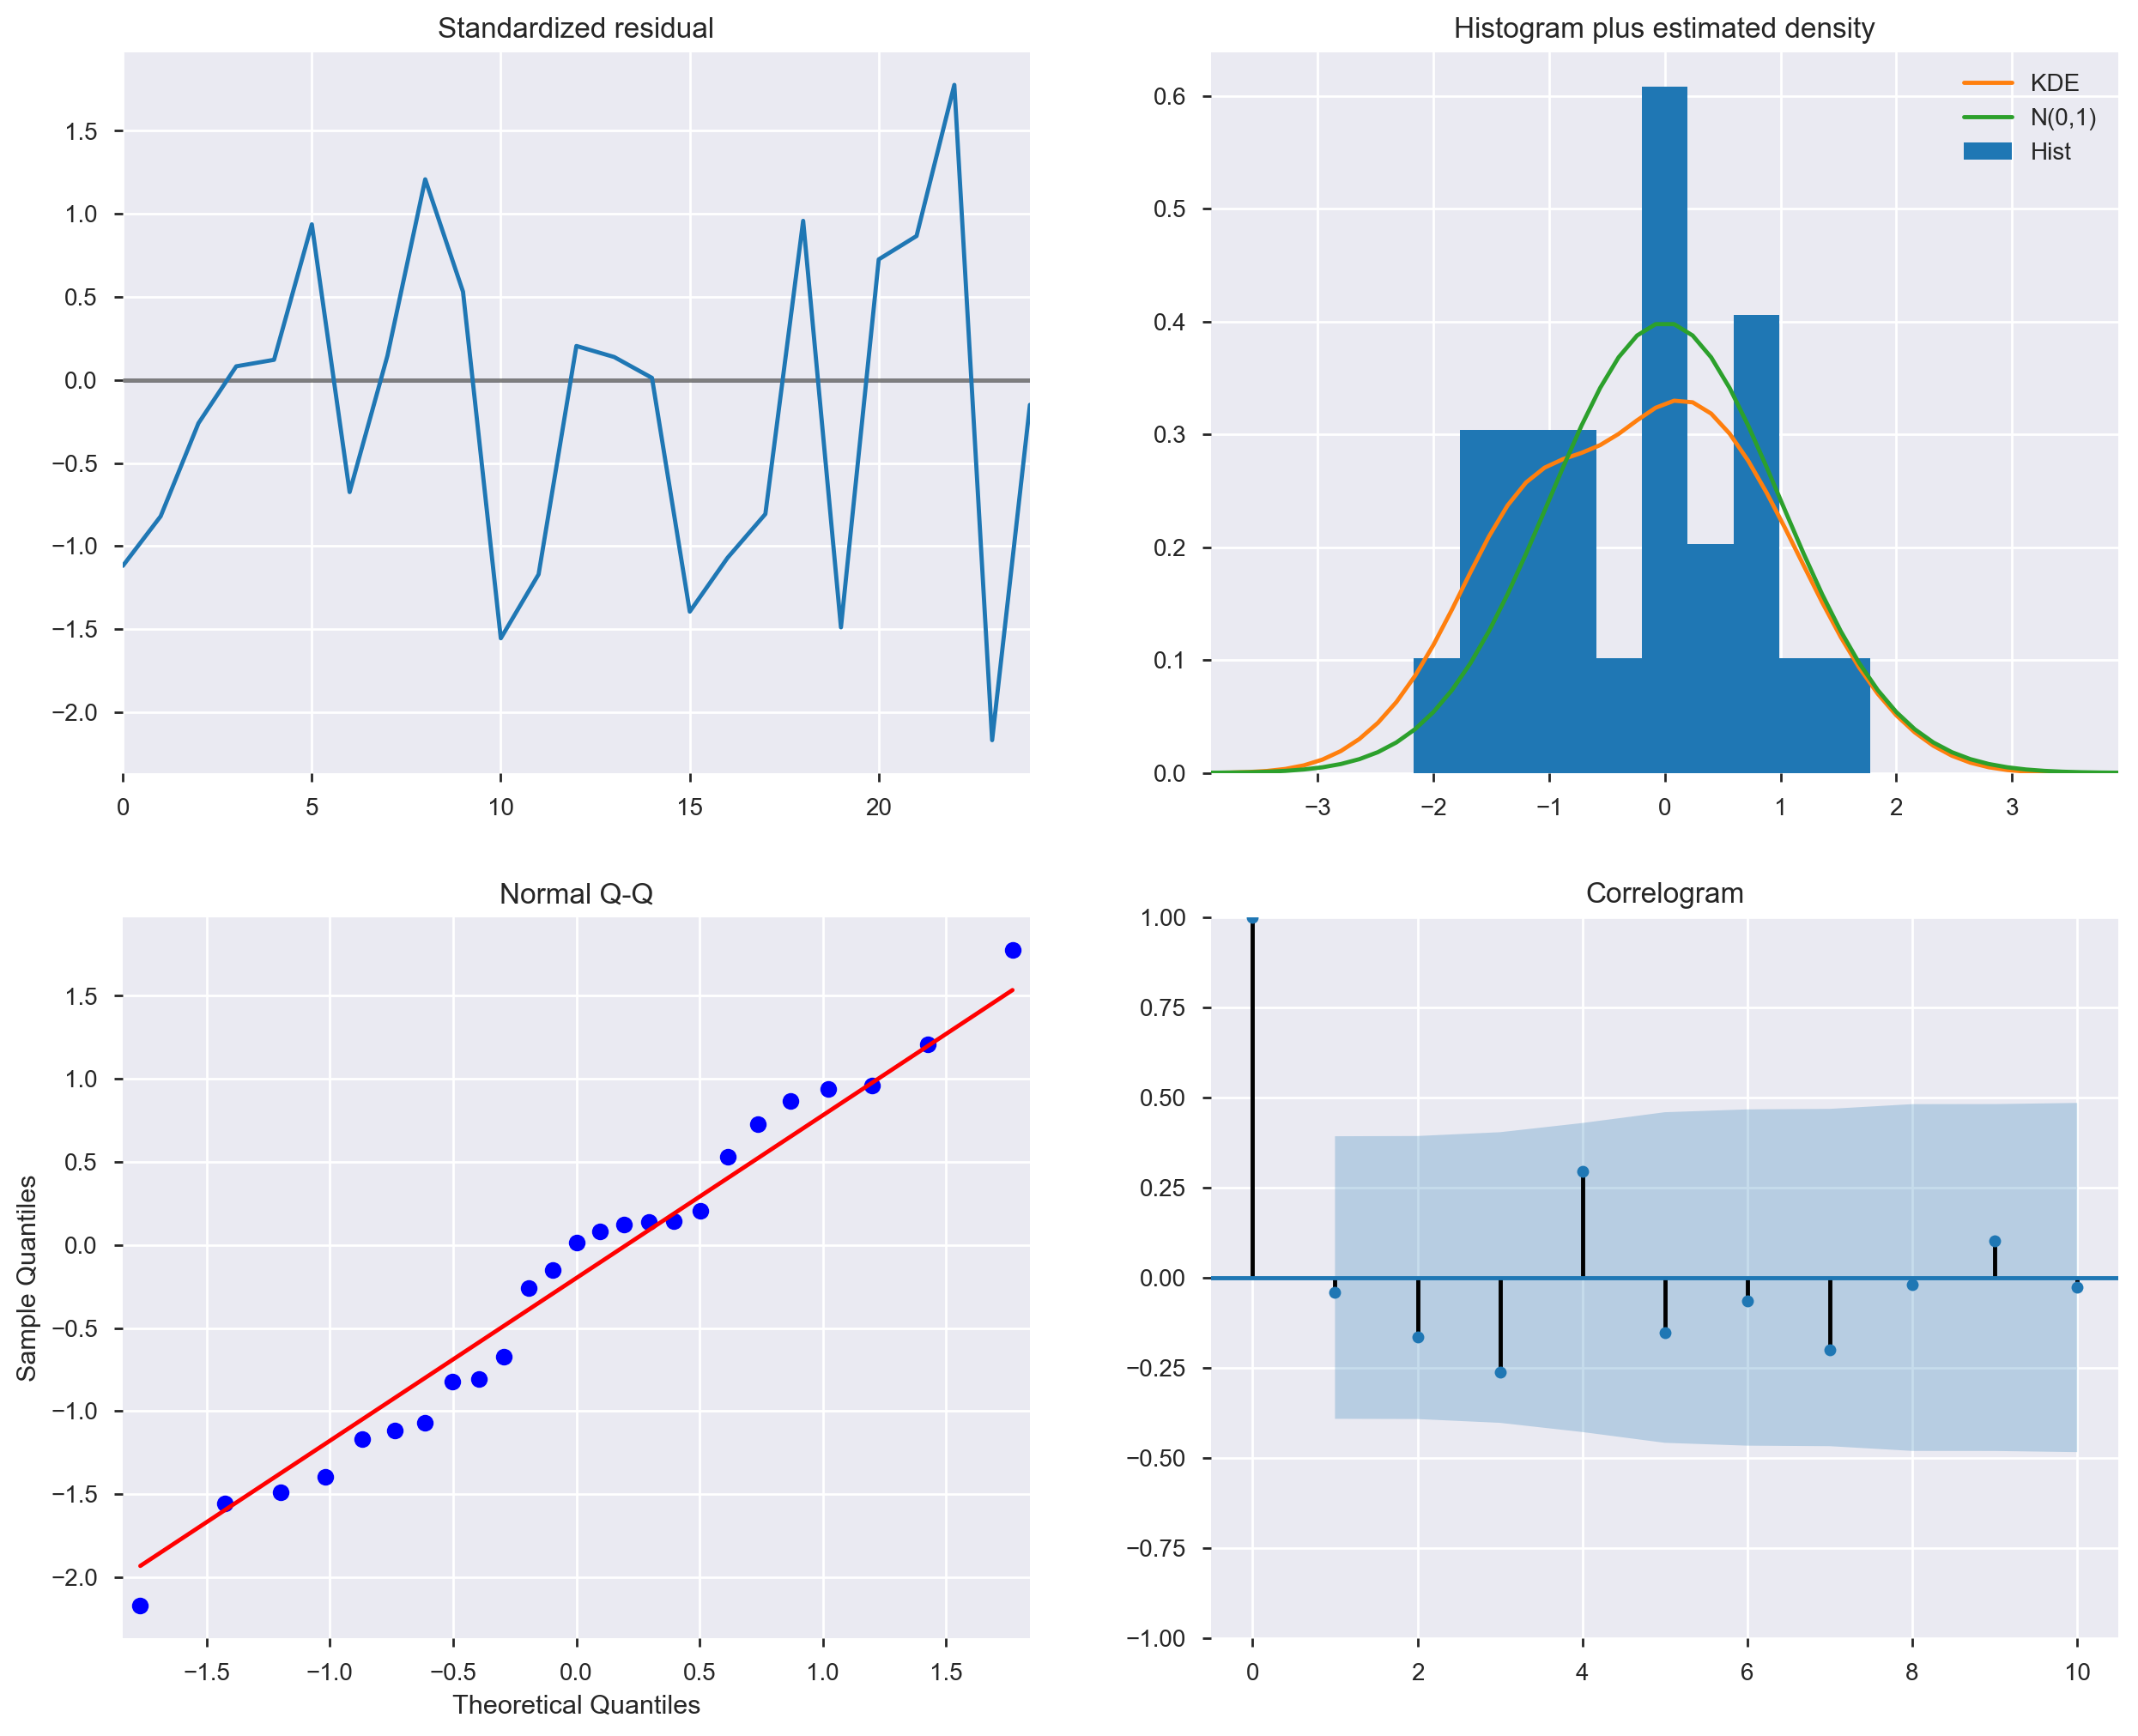

In [79]:
# 잔차 체크
f_clothes_week_results_final.plot_diagnostics(figsize=(15, 12))
plt.show()

In [80]:
# Get forecast 1 step ahead in future
f_clothes_week_pred_uc_final = f_clothes_week_results_final.get_forecast(steps=1)

In [81]:
# Get confidence intervals of forecasts
f_clothes_week_pred_ci_final = np.exp(f_clothes_week_pred_uc_final.conf_int())

## REGRESSION

In [82]:
f_clothes_week_X2_final = f_clothes_week_reg2.iloc[:,1:4]
f_clothes_week_y2_final = f_clothes_week_reg2.iloc[:,4]

In [83]:
lm=linear_model.LinearRegression(normalize=True)
f_clothes_week_model_final=lm.fit(f_clothes_week_X2_final,f_clothes_week_y2_final)

In [84]:
f_clothes_week_pred_final = lm.predict(f_clothes_week_X2_final)

In [86]:
f_clothes_week_X2_2_final = sm.add_constant(f_clothes_week_X2_final)
f_clothes_week_est3_final = sm.OLS(f_clothes_week_y2_final, f_clothes_week_X2_2_final)
f_clothes_week_est4_final = f_clothes_week_est3_final.fit()
print(f_clothes_week_est4_final.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_PD_BUY_TO   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     29.58
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           9.89e-08
Time:                        23:15:34   Log-Likelihood:                 31.104
No. Observations:                  25   AIC:                            -54.21
Df Residuals:                      21   BIC:                            -49.33
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           19.8327      0.140    141.528   

In [87]:
# prediction할 row
f_clothes_regdata_final = f_clothes_regdata_final[['HITS_SEQ','holiday','naver_search']]
f_clothes_regdata_final_row = f_clothes_regdata_final.iloc[-1,:]

In [88]:
# ARIMA, Linear Regression, ensemble 값을 보여줄 데이터프레임 만들기
f_clothes_regdata_final_row_df = pd.DataFrame(f_clothes_regdata_final_row).transpose()

In [89]:
f_clothes_regdata_val_final_pred = lm.predict(f_clothes_regdata_final_row_df)

In [90]:
f_clothes_results_arima_final = Series(np.exp(f_clothes_week_pred_uc_final.predicted_mean)).reset_index()
f_clothes_results_arima_final.drop('index',axis=1,inplace=True)

f_clothes_regdata_val_final_pred = Series(np.exp(f_clothes_regdata_val_final_pred))

In [92]:
f_clothes_results_all_final = pd.concat([f_clothes_results_arima_final, f_clothes_regdata_val_final_pred], axis=1)
f_clothes_results_all_final.columns = ['f_clothes_results_arima_final','f_clothes_results_reg_final']

In [93]:
f_clothes_results_all_final['ensemble'] = (f_clothes_results_all_final['f_clothes_results_arima_final'] + f_clothes_results_all_final['f_clothes_results_reg_final'])/2

In [94]:
f_clothes_results_all_final

,f_clothes_results_arima_final,f_clothes_results_reg_final,ensemble
0,1.072276e+09,1.165619e+09,1.118948e+09
